# Introducción
En este proyecto se desarrolla un sistema de detección de anomalías en series temporales mediante redes neuronales recurrentes(RNN); particularmente un modelo del tipo LSTM (Long Short-Term Memory), una arquitectura especialmente diseñada para modelar datos secuenciales.

El objetivo principal es identificar comportamientos atípicos en el valor del Índice de Precios y Cotizaciones (IPC) de la Bolsa Mexicana de Valores, los cuales pueden corresponder a eventos como caídas del sistema, ataques cibernéticos, eventos político-sociales, etc. 
Para ello, importaremos directamente de Yahoo Finance la información histórica que necesitamos.

La elección de un modelo LSTM se debe a su capacidad para capturar dependencias a largo plazo en secuencias temporales, lo cual resulta particularmente útil en este contexto.

El enfoque que se siguió en este proyecto fue el siguiente:

1. Entrenar un modelo LSTM sobre datos considerados normales, aprendiendo así el comportamiento esperado de la serie temporal.

2. Utilizar el modelo para predecir futuros valores y calcular el error de predicción.

3. Detectar anomalías cuando el error supera un umbral estadístico, indicando que el comportamiento actual se desvía significativamente del patrón aprendido.

Este sistema permite evaluar y visualizar de manera clara las anomalías en nuevas muestras de datos, y puede adaptarse fácilmente a distintos dominios como monitoreo de servidores, sensores industriales o aplicaciones financieras.



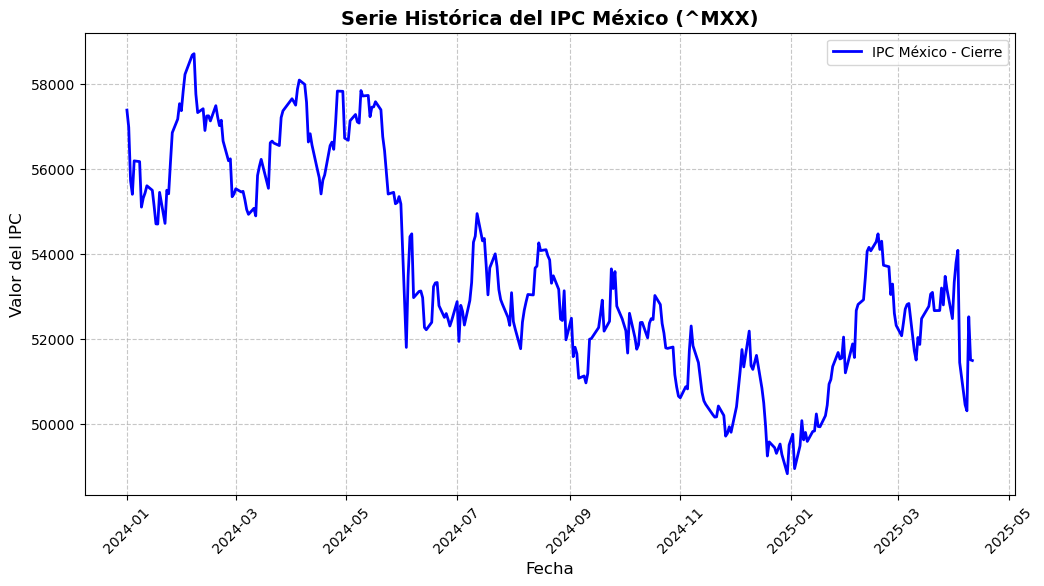

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Importar los datos
ipc = pd.read_csv("MXX.csv", parse_dates=['Fecha'], index_col='Fecha', dayfirst=True)

# Convertir la columna 'Cierre' a tipo 'numeric' (quitar las comas)
ipc['Cierre'] = ipc['Cierre'].str.replace(',', '').astype(float)

# Tirar los valores vacíos
serie = ipc[['Cierre']].dropna()

# Generar una gráfica
plt.figure(figsize=(12, 6))
plt.plot(serie.index, serie['Cierre'], label='IPC México - Cierre', color='blue', linewidth=2)
plt.title('Serie Histórica del IPC México (^MXX)', fontsize=14, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor del IPC', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.show()

In [46]:
# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
valores_norm = scaler.fit_transform(serie)

# División de los datos en entrenamiento y prueba (80% - 20%)
n_entrenamiento = int(len(valores_norm) * 0.8)
train_data = valores_norm[:n_entrenamiento]
test_data = valores_norm[n_entrenamiento:]

# Función para crear las secuencias 
def crear_secuencias(data, ventana):
    X, y = [], []
    for i in range(len(data) - ventana):
        X.append(data[i:i + ventana])
        y.append(data[i + ventana])
    return np.array(X), np.array(y)

# Crear las secuencias para el modelo
ventana = 30  # 30 días como ventana de contexto
X_train, y_train = crear_secuencias(train_data, ventana)
X_test, y_test = crear_secuencias(test_data, ventana)

# Ajustar la forma de los datos para que sean adecuados para LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Verificar las dimensiones de los datos de entrenamiento y prueba
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")


Forma de X_train: (227, 30, 1)
Forma de X_test: (35, 30, 1)


In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Crear el modelo LSTM
modelo = Sequential()

# Capa LSTM
modelo.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
modelo.add(Dropout(0.2))

# Segunda capa LSTM
modelo.add(LSTM(units=50, return_sequences=False))
modelo.add(Dropout(0.2))

# Capa de salida
modelo.add(Dense(units=1))

# Compilación del modelo
modelo.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
modelo.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/30


C:\Users\josue\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.0933 - val_loss: 0.0433
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0214 - val_loss: 0.0344
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0143 - val_loss: 0.1085
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0173 - val_loss: 0.0746
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0113 - val_loss: 0.0371
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0126 - val_loss: 0.0401
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0110 - val_loss: 0.0553


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


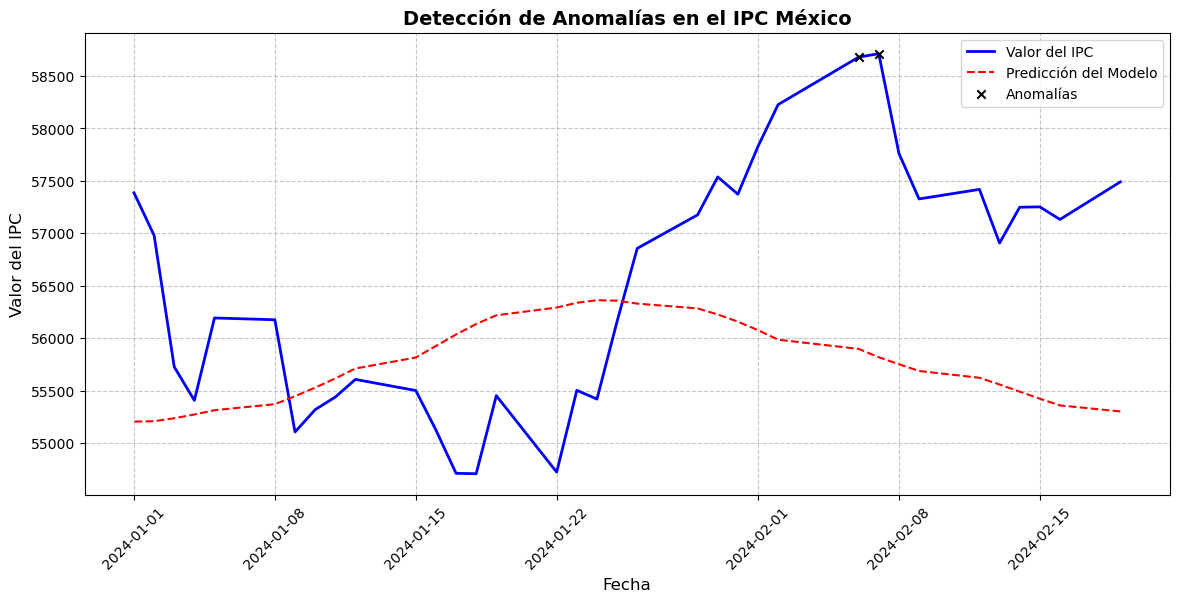

In [58]:
# Realizar predicciones en el conjunto de prueba
predicciones = modelo.predict(X_test)

# Invertir la normalización de las predicciones y los valores reales
predicciones = scaler.inverse_transform(predicciones)
y_test_invertido = scaler.inverse_transform(y_test.reshape(-1,1))

# Calcular los errores de predicción
errores = np.abs(predicciones - y_test_invertido)

# Establecer un umbral para detectar anomalías
percentil_95 = np.percentile(errores, 95)
umbral = percentil_95

# Detectar anomalías
anomalias = errores > umbral

# Visualización de los resultados

predicciones = predicciones.flatten()
fechas_test = serie.index[-len(y_test_invertido):]

plt.figure(figsize=(14, 6))
plt.plot(fechas_test, y_test_invertido, label='Valor del IPC', color='blue', linewidth=2)
plt.plot(fechas_test, predicciones, label='Predicción del Modelo', color='red', linestyle='dashed')
plt.scatter(fechas_test[anomalias.flatten()], y_test_invertido[anomalias.flatten()],
            color='black', label='Anomalías', zorder=3, marker='x')
plt.title('Detección de Anomalías en el IPC México', fontsize=14, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor del IPC', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()
